Battery Life Prediction using Deep Learning

This script implements a deep learning model for predicting battery remaining useful life (RUL)
using a combination of CNNs and RNNs. It processes both simulation and experimental data
to train and evaluate the model.

Key Features:
- Depthwise separable convolution for feature extraction
- GRU-based recurrent networks for temporal modeling
- Multi-modal data fusion (simulation + experimental)

Date: 2025


In [1]:
import os

import matplotlib.pyplot as plt
import numpy
import numpy as np
import gc
import scipy.io
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import init
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def test_accuracy_cal(predictions, test_label):
    """
 Calculate comprehensive test accuracy metrics for battery life prediction

 Args:
     predictions (torch.Tensor): Predicted RUL values
     test_label (torch.Tensor): True RUL values

 Returns:
     tuple: RMSE, MAE, MAPE, R2 metrics as numpy arrays
 """
    # Root Mean Square Error
    test_rmse = torch.sqrt(torch.mean(torch.square(predictions - test_label)))

    # Mean Absolute Error
    test_mae = torch.mean(torch.abs(predictions - test_label))

    # Mean Absolute Percentage Error
    test_mape = torch.mean(torch.abs(predictions - test_label) / test_label)

    # Mean Square Error for R2 calculation
    mse = torch.mean(torch.square(predictions - test_label))

    # R-squared coefficient
    test_r2 = 1 - mse / torch.var(predictions)


    return (test_rmse.cpu().detach().numpy(),
            test_mae.cpu().detach().numpy(),
            test_mape.cpu().detach().numpy(),
            test_r2.cpu().detach().numpy())


def moving_average(data, n=3):
    """
 Apply moving average smoothing to time series data

 Args:
     data (numpy.array): Input time series data
     n (int): Window size for moving average

 Returns:
     numpy.array: Smoothed data
 """
    data_output = np.copy(data)
    for i in range(len(data)):
        if i + n < len(data):
            data_output[i + n] = np.sum(data[i:i + n], axis=0) / n
    return data_output




In [4]:
# Calibration Cycle life
Cyclelife_1 = [1217, 1247, 1234, 1223, 843, 1085, 1135, 687, 616, 862, 197, 297, 398, 385, 602, 197, 303, 107, 66, 49, 119]
Cyclelife_2 = [1183, 1650, 1846, 1515, 854, 1224, 652, 816, 966, 798, 256, 189, 568, 509, 493, 119, 317, 64, 154, 59, 130]
Cyclelife_3 = [1291, 887, 1244, 1124, 551, 1524, 934, 572, 521, 616, 253, 234, 343, 479, 523, 198, 465, 115, 89, 47, 116]
Cyclelife_4 = [1648, 841, 1616, 1332, 667, 1221, 605, 719, 526, 704, 456, 364, 314, 425, 517, 104, 247, 252, 65, 111, 127]

In [5]:
Cyclelife_1 = numpy.array(Cyclelife_1).reshape(-1,1)
Cyclelife_2 = numpy.array(Cyclelife_2).reshape(-1,1)
Cyclelife_3 = numpy.array(Cyclelife_3).reshape(-1,1)
Cyclelife_4 = numpy.array(Cyclelife_4).reshape(-1,1)
Cyclelife_all = numpy.concatenate((Cyclelife_1, Cyclelife_2, Cyclelife_3, Cyclelife_4), axis=1)

In [6]:
def extract_feature(batch_name, battery_number, data_simulation, data_CM):
    
    data_all = data_simulation

    Cyclelife = data_all[batch_name][0, battery_number][0][0][0][3][0,0]

    discharge_t = []
    discharge_v = []
    discharge_tb = []
    discharge_Vo = []
    discharge_Vsn = []
    discharge_Vsp = []
    discharge_qnB = []
    discharge_qnS = []
    discharge_qpB = []
    discharge_qpS = []
    discharge_qMax = []
    discharge_Ro = []
    discharge_D = []
    
    for i in range(len(data_all[batch_name][0, battery_number][2][0])):
        discharge_t.append(data_all[batch_name][0, battery_number][2][0][i][0])
        discharge_v.append(data_all[batch_name][0, battery_number][2][0][i][1])
        discharge_tb.append(data_all[batch_name][0, battery_number][2][0][i][2])
        discharge_Vo.append(data_all[batch_name][0, battery_number][2][0][i][3])
        discharge_Vsn.append(data_all[batch_name][0, battery_number][2][0][i][4])
        discharge_Vsp.append(data_all[batch_name][0, battery_number][2][0][i][5])
        discharge_qnB.append(data_all[batch_name][0, battery_number][2][0][i][6])
        discharge_qnS.append(data_all[batch_name][0, battery_number][2][0][i][7])
        discharge_qpB.append(data_all[batch_name][0, battery_number][2][0][i][8])
        discharge_qpS.append(data_all[batch_name][0, battery_number][2][0][i][9])
        discharge_qMax.append(data_all[batch_name][0, battery_number][2][0][i][10])
        discharge_Ro.append(data_all[batch_name][0, battery_number][2][0][i][11])
        discharge_D.append(data_all[batch_name][0, battery_number][2][0][i][12])

    discharge_t = numpy.array(discharge_t)
    discharge_v = numpy.array(discharge_v)
    discharge_tb = numpy.array(discharge_tb)
    discharge_Vo = numpy.array(discharge_Vo)
    discharge_Vsn = numpy.array(discharge_Vsn)
    discharge_Vsp = numpy.array(discharge_Vsp)
    discharge_qnB = numpy.array(discharge_qnB)
    discharge_qnS = numpy.array(discharge_qnS)
    discharge_qpB = numpy.array(discharge_qpB)
    discharge_qpS = numpy.array(discharge_qpS)
    discharge_qMax = numpy.array(discharge_qMax)
    discharge_Ro = numpy.array(discharge_Ro)
    discharge_D = numpy.array(discharge_D)

    window_len = 3
    
    discharge_t = moving_average(discharge_t, n=window_len)
    discharge_v = moving_average(discharge_v, n=window_len)
    discharge_tb = moving_average(discharge_tb, n=window_len)
    discharge_Vo = moving_average(discharge_Vo, n=window_len)
    discharge_Vsn = moving_average(discharge_Vsn, n=window_len)
    discharge_Vsp = moving_average(discharge_Vsp, n=window_len)
    discharge_qnB = moving_average(discharge_qnB, n=window_len)
    discharge_qnS = moving_average(discharge_qnS, n=window_len)
    discharge_qpB = moving_average(discharge_qpB, n=window_len)
    discharge_qpS = moving_average(discharge_qpS, n=window_len)
    discharge_qMax = moving_average(discharge_qMax, n=window_len)
    discharge_Ro = moving_average(discharge_Ro, n=window_len)
    discharge_D = moving_average(discharge_D, n=window_len)

    data_all = data_CM
    
    charge_V = data_all[batch_name][0, battery_number][0][0][0][0]
    charge_I = data_all[batch_name][0, battery_number][0][0][0][1]
    charge_Q = data_all[batch_name][0, battery_number][0][0][0][2]
    charge_T = data_all[batch_name][0, battery_number][0][0][0][3]
    charge_E = data_all[batch_name][0, battery_number][0][0][0][4]
    charge_dQdV = data_all[batch_name][0, battery_number][0][0][0][5]
    charge_t_s = data_all[batch_name][0, battery_number][0][0][0][6]
    discharge_V = data_all[batch_name][0, battery_number][0][0][0][7]
    discharge_I = data_all[batch_name][0, battery_number][0][0][0][8]
    discharge_Q = data_all[batch_name][0, battery_number][0][0][0][9]
    discharge_T = data_all[batch_name][0, battery_number][0][0][0][10]
    discharge_E = data_all[batch_name][0, battery_number][0][0][0][11]
    discharge_dQdV = data_all[batch_name][0, battery_number][0][0][0][12]
    discharge_t_s = data_all[batch_name][0, battery_number][0][0][0][13]
   
    Cyclelife = min(Cyclelife, Cyclelife_all[int(batch_name[-2:])-1, battery_number])
                                  
    RUL = numpy.arange(Cyclelife, 0, -1).reshape(-1, 1) * 1.0

    discharge_feature_VIT = numpy.concatenate((discharge_V[:, None, :], discharge_Q[:, None, :], discharge_t_s[:, None, :]), axis=1)

    discharge_feature_Simulation = numpy.concatenate((discharge_Vo, discharge_Vsn, discharge_qnB, discharge_Ro), axis=1)
    
    discharge_feature1 = numpy.concatenate((discharge_feature_VIT[0:Cyclelife], discharge_feature_Simulation[0:Cyclelife]), axis = 1)
  
    discharge_feature2 = discharge_feature1 - discharge_feature1[0,:]
    discharge_feature = numpy.concatenate((discharge_feature1[1:, :], discharge_feature2[1:, :]), axis=1)

    return discharge_feature, RUL[1:Cyclelife]
    

In [7]:

def weighted_moving_average(data, window_size):
    weights = numpy.arange(1, window_size + 1) * 1.0
    weights = weights / numpy.sum(weights)
    smoothed_data = numpy.convolve(data.reshape(-1, ), weights, mode='same')
    data_sum = 0
    for i in range(window_size):
        data_sum = data_sum + data[i]
        smoothed_data[i] = data_sum / (i + 1)
    return smoothed_data

In [8]:
class DepthwiseSeparableConvolution(nn.Module):
    """
     Depthwise Separable Convolution layer for efficient feature extraction
    
     This reduces computational cost while maintaining representational power
     by factorizing standard convolution into depthwise and pointwise operations.
     """

    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()

        # Depthwise convolution: applies one filter per input channel
        self.depthwise_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=in_ch,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_ch  # Key: number of groups equals input channels
        )

        # Pointwise convolution: 1x1 conv to combine features across channels
        self.pointwise_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=1,
            stride=1,
            padding=0,
            groups=1
        )

    def forward(self, x):
        out = self.depthwise_conv(x)
        out = self.pointwise_conv(out)
        return out


class Net(nn.Module):
    """
     Hybrid CNN-RNN Neural Network for Battery Life Prediction
    
     Architecture:
     - Depthwise separable convolutions for spatial feature extraction
     - GRU for temporal sequence modeling
     - Fully connected layers for final RUL prediction
     """

    def __init__(self, input_channels=2, image_size=100, life_linear=1000):
        """
          Initialize the neural network
        
          Args:
              input_channels (int): Number of input feature channels
              image_size (int): Size of input feature maps
              life_linear (int): Input size for final linear layers
        """
        super(Net, self).__init__()

        # Convolutional feature extraction layers
        self.DepthwiseSeparableConvolution1 = DepthwiseSeparableConvolution(input_channels, 32)
        self.DepthwiseSeparableConvolution2 = DepthwiseSeparableConvolution(32, 16)
        self.DepthwiseSeparableConvolution3 = DepthwiseSeparableConvolution(16, 8)

        # Recurrent layers for temporal modeling
        self.rnn1 = nn.GRU(100, 200, batch_first=True)
        self.rnn2 = nn.GRU(200, 200, batch_first=True)

        # Pooling layer for dimensionality reduction
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Final prediction layers
        self.life = nn.Sequential(
            nn.Linear(life_linear, 600),
            nn.ReLU(),
            nn.Linear(600, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor with shape (batch, channels, height, width)

        Returns:
            torch.Tensor: Predicted RUL values
        """
        # CNN pathway for spatial features
        out_cnn = self.pool(self.DepthwiseSeparableConvolution1(x))
        out_cnn = self.pool(self.DepthwiseSeparableConvolution2(out_cnn))
        out_cnn = self.DepthwiseSeparableConvolution3(out_cnn)
        out_cnn = out_cnn.view(-1, self.num_flat_features(out_cnn))

        # RNN pathway for temporal features
        out_rnn, _ = self.rnn1(x.squeeze(1))
        out_rnn = out_rnn[:, -1]  # Take last timestep output

        # Fusion of CNN and RNN features
        out_fused = torch.cat((out_cnn, out_rnn), dim=1)

        # Final prediction
        out = self.life(out_fused)
        return out

    def num_flat_features(self, x):
        """Calculate number of features after flattening"""
        size = x.size()[1:]  # All dimensions except batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def initialize_weights(self):
        """Initialize network weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data, 0, 0.01)
                m.bias.data.zero_()


In [9]:
# Loading data
data_simulation = scipy.io.loadmat(r'SimulationData_RetiredBattery.mat')['SimulationData_RetiredBattery'][0, 0]

data_CM = scipy.io.loadmat(r'RetiredBatteryData_all.mat')['RetiredBatteryData_all'][0, 0]
# 'batch18', 'batch19', 'batch20',
batch_list = [ 'batch01', 'batch02','batch03','batch04','batch05','batch06','batch07',\
              'batch08','batch09','batch10','batch11','batch12','batch13','batch14',\
            'batch15','batch16','batch17','batch18','batch19','batch20', 'batch21']

In [10]:
batch_list1 = ['batch16','batch18', 'batch19','batch20','batch21']

train_discharge_feature1 = numpy.array([])
train_label1 = numpy.array([])
copy_number = 0
for batch_name in batch_list1:
    for battery_num in [1, 2, 3]:
        discharge_feature, RUL = extract_feature(batch_name, battery_num, data_simulation, data_CM)
#         copy_number = int(300/RUL[0])
#       print(copy_number)
        for i in range(copy_number+1):
            try:
                train_discharge_feature1 = numpy.concatenate((train_discharge_feature1, discharge_feature), axis=0)
                train_label1 = numpy.concatenate((train_label1, RUL), axis=0)
            except:
                train_discharge_feature1 = discharge_feature
                train_label1 = RUL

print(train_discharge_feature1.shape)
print(train_label1.shape)

test_discharge_feature = numpy.array([])
test_label = numpy.array([])
test_index = [0]
for batch_name in batch_list1:
    for battery_num in [0]:
        discharge_feature, RUL = extract_feature(batch_name, battery_num, data_simulation, data_CM)
        try:
            test_discharge_feature = numpy.concatenate((test_discharge_feature, discharge_feature), axis=0)
            test_label = numpy.concatenate((test_label, RUL), axis=0)
        except:
            test_discharge_feature = discharge_feature
            test_label = RUL
        test_index.append(len(test_discharge_feature))
print(test_discharge_feature.shape)

(1617, 14, 100)
(1617, 1)
(500, 14, 100)


In [11]:
# Norm
max_discharge_feature = numpy.max(train_discharge_feature1, axis=2).max(0)[None, :, None]
min_discharge_feature = numpy.min(train_discharge_feature1, axis=2).min(0)[None, :, None]
train_discharge_feature1 = 2 * (train_discharge_feature1 - min_discharge_feature) / (
        max_discharge_feature - min_discharge_feature) - 1
test_discharge_feature = 2 * (test_discharge_feature - min_discharge_feature) / (
        max_discharge_feature - min_discharge_feature) - 1

test_discharge_feature[numpy.where(test_discharge_feature > 1)] = 1
test_discharge_feature[numpy.where(test_discharge_feature < -1)] = -1


In [19]:

'''
    Training model
'''

batch_size = 128*8
epochs = 5000
lr = 0.0005
drop_rate = 0.005

interval = 1
# training dataset1
train_x1 = torch.tensor(train_discharge_feature1[:,None,:,::interval], dtype=torch.float32)
train_y1 = torch.tensor(train_label1, dtype=torch.float32)
print(train_x1.shape,train_y1.shape, batch_size)
train_datset1 = TensorDataset(train_x1, train_y1)
train_loader1 = DataLoader(train_datset1, shuffle=False, batch_size=batch_size)

model = Net(input_channels=train_x1.shape[1],image_size=train_x1.shape[2], life_linear=800)
model.initialize_weights()


torch.Size([1617, 1, 14, 100]) torch.Size([1617, 1]) 1024


In [ ]:

device = "cuda"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss().to(device)
# loss_func = MAPELoss().to(device)

Loss = []
for i in range(epochs):
    rul_pred_loss1 = 0
    for step, (batch_x, batch_y) in enumerate(train_loader1):
#         loss_func = nn.MSELoss().to(device)
        model.train()
        optimizer.zero_grad()
        rul_pred = model(batch_x.to(device))
        loss = loss_func(rul_pred.to(device), batch_y.reshape(-1, 1).to(device))
        loss.backward()
        rul_pred_loss1 = rul_pred_loss1 + loss.cpu().detach().numpy()
        optimizer.step()
    
    
    Loss.append(rul_pred_loss1)
              
    if i % 10 ==0:
        print(i, rul_pred_loss1)
        
#     if rul_pred_loss1<20:
#         break
    
    gc.collect()
    torch.cuda.empty_cache()
    
plt.plot(Loss)
plt.show()

6.924456 5.4310045 0.19719285 0.98289543


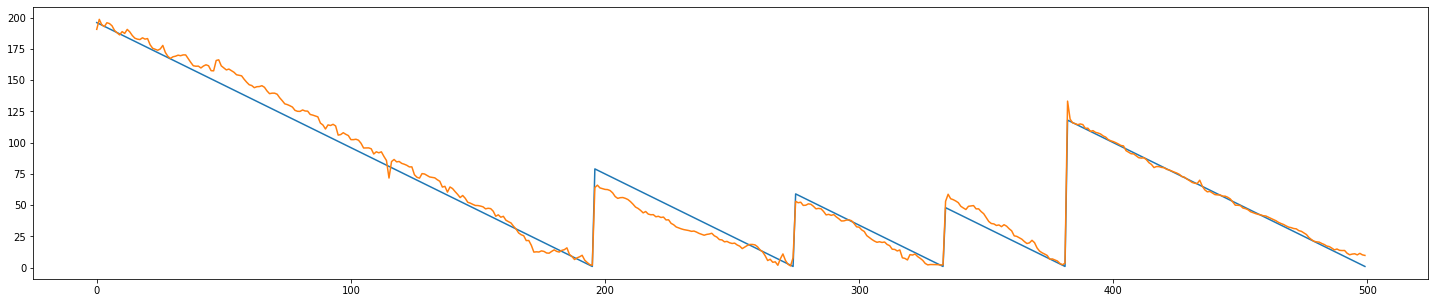

In [25]:
'''
    Testing model
'''

test_data = torch.tensor(test_discharge_feature[:,None,:,::interval], dtype=torch.float32).to(device)
test_label_ = torch.tensor(test_label, dtype=torch.float32)
test_datset = TensorDataset(test_data, test_label_)
test_loader = DataLoader(test_datset, shuffle=False, batch_size=batch_size)

model.eval()
# model.train()
model.to(device)
test_pred_all = torch.tensor([]).to(device)
for step, (batch_x, batch_y) in enumerate(test_loader):
    test_pred_temp = model(batch_x).to(device)
    test_pred_all = torch.cat((test_pred_all, test_pred_temp), dim=0)

test_pred = test_pred_all.reshape(-1, 1)
test_rmse, test_mae, test_mape, test_r2 = test_accuracy_cal(test_pred.to(device), test_label_.to(device))
print(test_rmse, test_mae, test_mape, test_r2)

cycle = numpy.array(range(len(test_label)))
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(cycle, test_label)
plt.plot(cycle, test_pred.cpu().detach().numpy())
plt.show()

In [26]:
# Saving model

Saving_name = 'Cluster1_test0_cali'
torch.save(model, 'Trained_model/'+ Saving_name +'.pth')
loaded_model = torch.load('Trained_model/' + Saving_name+ '.pth')
model = loaded_model

4.1947556 3.7252982 0.19522165 0.9925497


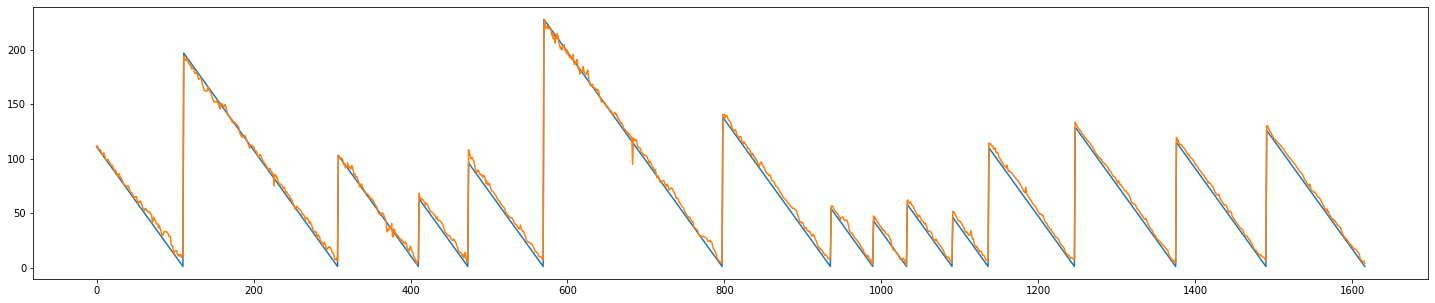

In [29]:

'''
    Training model
'''
# device="cuda"
train_data = torch.tensor(train_discharge_feature1[:,None,:,::interval], dtype=torch.float32)
train_label_ = torch.tensor(train_label1, dtype=torch.float32)

model.to(device)
train_pred = model(train_data.to(device))
train_rmse, train_mae, train_mape, train_r2 = test_accuracy_cal(train_pred.cpu(), train_label_.cpu())

print(train_rmse, train_mae, train_mape, train_r2)

fig, ax = plt.subplots(figsize=(25, 5))
cycle = numpy.array(range(len(train_label1)))
plt.plot(cycle, train_label1)
plt.plot(cycle,train_pred.cpu().detach().numpy())
plt.show()

In [30]:
# Saving results
import scipy.io as sio

data_all = {'test_rmse':test_rmse, 'test_mae':test_mae, 'test_mape':test_mape, 'test_r2':test_r2,
           'test_label':test_label, 'test_pred':test_pred.cpu().detach().numpy(), 'batch_list':batch_list, 'test_index':test_index}

sio.savemat('Results/'+ Saving_name +'.mat', data_all)